This is a slightly involved classification notebook - using superpixels to generate features. The results look good in that we reduce commission errors. The segmentation might be 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from rscube.nd_tools import (get_array_from_features, 
                             get_features_from_array, 
                             get_superpixel_area_as_features, 
                             get_superpixel_means_as_features,
                             get_superpixel_stds_as_features, 
                             scale_img)
from rscube.rio_tools import (get_geopandas_features_from_array, 
                              rasterize_shapes_to_array, 
                              get_indices_from_extent, get_cropped_profile)

from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from pprint import pprint
import geopandas as gpd
from rasterio import plot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import geopandas as gpd
from shapely.geometry import box
from rasterio.windows import Window
from pathlib import Path
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import joblib

In [3]:
PLANET_ID = '20211003_161639_91_241d'

In [4]:
planet_image_path = Path(f'local_chips/{PLANET_ID}_3B_AnalyticMS_SR_8b.tif')
planet_image_path.exists()

True

# Path

In [5]:
out_class_dir = Path(f'classification_outputs_peckel/{PLANET_ID}')
out_class_dir.mkdir(exist_ok=True, parents=True)

# Load Chips

Want to crop image based on chip

In [6]:
df = gpd.read_file('chips.geojson')
df.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


In [7]:
with rasterio.open(planet_image_path) as ds:
    image_crs = ds.crs
    image_box = box(*ds.bounds)
    image_bounds = list(ds.bounds)
    image_profile = ds.profile
    image_shape = image_profile['height'], image_profile['width']

image_shape

(10003, 13622)

In [8]:
df_utm = df.to_crs(image_crs)
intersects = df_utm.geometry.intersects(image_box)
df_chip = df_utm[intersects].reset_index(drop=True)
df_chip.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-95.866875,33.03,3,3_40,2011-07-10,1,42,"POLYGON ((222530.752 3668526.777, 241571.451 3..."


It's a little weird because all Planet Imagery is in UTM and Chips are in Lon/Lat.

In [9]:
(start_y, start_x), (stop_y, stop_x) = get_indices_from_extent(image_profile['transform'],
                                                               list(df_chip.total_bounds),
                                                               shape=image_shape)
window = Window.from_slices((start_y, stop_y), (start_x, stop_x))
sx, sy = np.s_[start_x: stop_x], np.s_[start_y: stop_y]
profile_cropped = get_cropped_profile(image_profile, sx, sy)

We are going to label things based on the chip index.

In [10]:
index = df_chip.random_id[0]
index

42

In [11]:
with rasterio.open(planet_image_path) as ds:
    image_c = ds.read(window=window)
    image_c = image_c.transpose([1, 2, 0]).astype(np.float32)
image_c.shape

(6838, 6840, 8)

In [12]:
with rasterio.open(planet_image_path) as ds:

    t = ds.tags()
    d = ds.descriptions
    
list(enumerate(d))

[(0, 'coastal_blue'),
 (1, 'blue'),
 (2, 'green_i'),
 (3, 'green'),
 (4, 'yellow'),
 (5, 'red'),
 (6, 'rededge'),
 (7, 'nir')]

In [13]:
mask = (image_c[..., 0] == image_profile['nodata'])
image_c[mask, :] = np.nan

In [14]:
rgb = scale_img(image_c[..., [7, 5, 3]])
# plt.imshow(rgb)

In [15]:
image = image_c[..., [7, 5, 3]]

image_view = image.copy()
for k in tqdm(range(3)):
    m0 = np.nanpercentile(image[~mask, k], 2)
    m1 = np.nanpercentile(image[~mask, k], 98)
    image_view[~mask, k] = np.clip(image[~mask, k], m0, m1)

100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.58s/it]


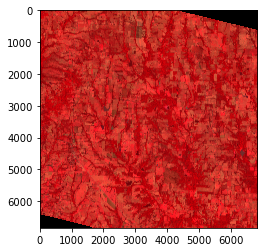

In [16]:
rgb = scale_img(image_view)
plt.imshow(rgb)

In [17]:
p_cropped = profile_cropped.copy()
p_cropped['count'] = 3
p_cropped['dtype'] = 'float32'
p_cropped['nodata'] = np.nan
with rasterio.open(out_class_dir / f'chip_cropped_{PLANET_ID}.tif', 'w', **p_cropped) as ds:
    ds.write(rgb.transpose([2, 0, 1]))

You could use the above to figure out some training data. We label it `training_data_{index}`, according to the chip ID.

# Segmentation

Going to use multiscale superpixels - see [this paper](https://www.mdpi.com/2072-4292/12/12/2048) and the references. I learned about them [here](https://link.springer.com/chapter/10.1007/978-94-017-7239-6_8).

Best discussion of felzenswalb algorithm (and parameters below) is by a fellow JPL team: https://ieeexplore.ieee.org/document/5593215

In [18]:
def get_segmentation(image, min_size):
    mask = np.isnan(image[..., 0])
    image_seg = image.copy()
    # So that np.nans don't give us problems
    image_seg[mask, :] = -10_000
    segments_fz = felzenszwalb(image_seg,
                               # may want to play with this
                               scale=.1, 
                               # normally gaussian filter is applied - can experiment
                               sigma=0.2,
                               # minimum size of segments
                               min_size=min_size
                              )
    return segments_fz

We are going to use the RGB image from above.

In [19]:
get_segmentation_partial = lambda min_size: get_segmentation(rgb, min_size)
segmentations = list(map(get_segmentation_partial, tqdm([5, 20, 50])))

100%|██████████████████████████████████████| 3/3 [06:58<00:00, 139.54s/it]


In [20]:
# X = segmentations[0].copy()
# X[mask] = 0
# superpixel_labels_viz = label2rgb(X, bg_label=0)
# plt.imshow(superpixel_labels_viz)

Below would be used to save the segments to a vector file. It takes some time and the segments can be approximately ~1 GB.

In [21]:
segments_fz = segmentations[1]

In [22]:
%%time

# features = get_geopandas_features_from_array(segments_fz.astype(np.int32), 
#                                              profile['transform'], 
#                                              label_name='label')

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 10.3 µs


In [23]:
%%time

# df_segments = gpd.GeoDataFrame.from_features(features)
# df_segments.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [24]:
%%time

# df_segments.crs = profile['crs']
# df_segments.to_file('segments.geojson', driver='GeoJSON')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


# Generate Features

In [25]:
rgb.shape

(6838, 6840, 3)

In [26]:
pixel_features = rgb.reshape((-1, rgb.shape[-1]))

In [27]:
multi_superpixel_features_mean = [get_superpixel_means_as_features(seg, rgb) for seg in tqdm(segmentations)]

100%|███████████████████████████████████████| 3/3 [00:21<00:00,  7.09s/it]


In [28]:
multi_superpixel_features_mean[0].shape

(3568916, 3)

In [29]:
multi_superpixel_features_std = [get_superpixel_stds_as_features(seg, rgb) for seg in tqdm(segmentations)]

  0%|                                               | 0/3 [00:00<?, ?it/s]/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:523: RuntimeWarning: invalid value encountered in divide
  means = sums / counts
100%|███████████████████████████████████████| 3/3 [00:25<00:00,  8.51s/it]


In [30]:
multi_superpixel_means = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_mean)]
multi_superpixel_stds = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_std)]

100%|███████████████████████████████████████| 3/3 [00:39<00:00, 13.28s/it]


In [31]:
scale_ind = 0
img_super = multi_superpixel_means[scale_ind]
p_superp = p_cropped.copy()
p_superp['count'] = 3

with rasterio.open(out_class_dir / f'superpixel_means_scale-{scale_ind}_{PLANET_ID}.tif', 'w', **p_superp) as ds:
    ds.write(img_super.transpose([2, 0, 1]))

In [32]:
superpixel_means_pixel_f = [superpixel_means.reshape((-1, rgb.shape[-1])) 
                            for superpixel_means in multi_superpixel_means]
superpixel_stds_pixel_f = [superpixel_stds.reshape((-1, rgb.shape[-1])) 
                            for superpixel_stds in multi_superpixel_stds]

In [33]:
all_features = np.hstack(([pixel_features]  
                          + superpixel_means_pixel_f 
                          + superpixel_stds_pixel_f
                         ))
all_features.shape

(46771920, 21)

# Generate Training Data

Using Peckel Occurance data to generate training data

In [34]:
from osgeo import gdal
from dem_stitcher.rio_window import read_raster_from_window
from rasterio.warp import transform_bounds

def build_peckel_vrt(extent: list, 
                     out_path: Path):
    df_peckel_data = gpd.read_file('peckel_tiles.geojson')
    bbox = box(*extent)
    ind_inter = df_peckel_data.geometry.intersects(bbox)
    df_subset = df_peckel_data[ind_inter].reset_index(drop=True)
    gdal.BuildVRT(str(out_path), df_subset.source_url.tolist())
    return out_path

def get_peckel_raster(extent:list) -> tuple:
    tmp_vrt = Path('peckel_data_tmp.vrt')
    build_peckel_vrt(extent, tmp_vrt)
    X, p = read_raster_from_window(tmp_vrt,
                                   extent,
                                   CRS.from_epsg(4326))
    tmp_vrt.unlink()
    p['driver'] = 'GTiff'
    return X, p

In [35]:
df_chip.to_crs(4326).total_bounds

array([-95.97375,  32.94   , -95.76   ,  33.12   ])

In [36]:
X_occ, p_occ = get_peckel_raster(df_chip.to_crs(4326).total_bounds)

In [37]:
with rasterio.open(out_class_dir / f'occurrence_{PLANET_ID}.tif', 'w', **p_occ) as ds:
    ds.write(X_occ, 1)

In [38]:
#plt.imshow(X_occ)

In [39]:
from scipy import ndimage

OCC_MIN = 20
DIST_TO_EXTENT = 5

water_ind = (X_occ >= OCC_MIN)
water_extent = (X_occ > 0)

water_extent_arr = (~water_extent).astype(int)
water_dist = ndimage.distance_transform_edt(water_extent_arr)

land_ind = water_dist > DIST_TO_EXTENT

Text(0.5, 1.0, 'Land Mask')

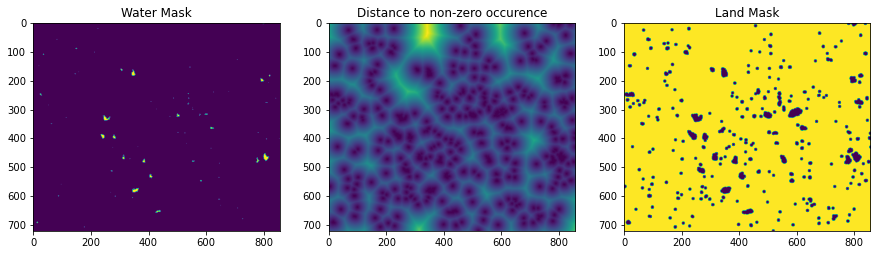

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(water_ind)
ax[0].set_title('Water Mask')

ax[1].imshow(water_dist)
ax[1].set_title('Distance to non-zero occurence')

ax[2].imshow(land_ind)
ax[2].set_title('Land Mask')

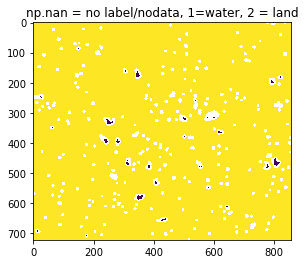

In [41]:
training_data_4326 = np.zeros(X_occ.shape) * np.nan
training_data_4326[land_ind] = 2
training_data_4326[water_ind] = 1
plt.title('np.nan = no label/nodata, 1=water, 2 = land')
plt.imshow(training_data_4326, interpolation='none')

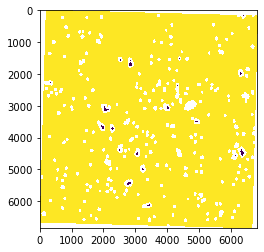

In [43]:
p_temp = p_occ.copy()
p_temp['dtype'] = 'float32'
p_temp['nodata'] = np.nan


training_data_r, p_r = reproject_arr_to_match_profile(training_data_4326, p_temp, p_cropped)

training_data_r = training_data_r[0, ...].round()

plt.imshow(training_data_r, interpolation='none')

In [44]:
with rasterio.open(out_class_dir/f'training_data_reprojected_{PLANET_ID}.tif', 'w', **p_r) as ds:
    ds.write(training_data_r, 1)

In [45]:
labels = training_data_r.copy()

In [46]:
labels_f = labels.reshape((-1, 1)).ravel()

f_mask = (~((labels_f == 0) | np.isnan(labels_f) | mask.ravel())).ravel()

In [47]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0,
                            n_jobs=8,
                            warm_start=True)


There must be a better way to do this - this makes sure training data has equal water and land, the later which is much more over-represented. Think something like this will do: https://imbalanced-learn.org/stable/auto_examples/applications/plot_multi_class_under_sampling.html#sphx-glr-auto-examples-applications-plot-multi-class-under-sampling-py/

In [48]:
X_labeled_all = all_features[f_mask]
y_labeled_all = labels_f[f_mask]

In [49]:
if (1 in np.unique(y_labeled_all)):
    PERCENT_OF_DATA = .05
    subset_of_data_pixels = (~f_mask).sum() * PERCENT_OF_DATA

    np.random.seed(0)
    water_ind_f = np.where(y_labeled_all == 1)[0]

    # Make sure training water never exceed more than p% of available data
    n_max = int(np.minimum(y_labeled_all.shape[0], subset_of_data_pixels))
    water_ind_f_sample = np.random.choice(water_ind_f, size=n_max)

    land_ind_f = np.where(y_labeled_all == 2)[0]
    n_land = int(np.minimum(water_ind_f_sample.shape[0], subset_of_data_pixels)) 
    land_ind_f_sample = np.random.choice(land_ind_f, size=n_land)

    indices_for_labeling = np.hstack([water_ind_f_sample, land_ind_f_sample])
    indices_for_labeling.shape

    y_labeled = y_labeled_all[indices_for_labeling].astype(int)
    X_labeled = X_labeled_all[indices_for_labeling, ...]

else:
    print(f'No water in training data: {1 not in np.unique(y_labeled_all)}')
    
    PERCENT_OF_DATA = .1
    land_ind_f = np.where(y_labeled_all == 2)[0]
    n = int(PERCENT_OF_DATA * (~f_mask).sum())
    land_ind_f_sample = np.random.choice(land_ind_f, size=n)
    
    
    y_labeled = y_labeled_all[land_ind_f_sample].astype(int)
    X_labeled = X_labeled_all[land_ind_f_sample, ...]


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, 
                                                    y_labeled, 
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=0,
                                                    # stratify=y_labeled
                                                    )

In [51]:
%%time

print(f'The Peckel data has water: {1 in np.unique(y_labeled_all)}')

rf_path = Path('rf.joblib')


if (1 not in np.unique(y_labeled_all)):
    rf_prev = joblib.load(rf_path)
    rf = rf_prev
    # see this discussion: https://stackoverflow.com/questions/42757892/how-to-use-warm-start
    # print(f'loading previously trained random forrest with {rf.n_estimators} trees and adding 250 more')

    # rf.set_params(n_estimators=(rf.n_estimators + 250))
    # print(f'now {rf.n_estimators} trees')
else:  
    rf.fit(X_train, 
           y_train)


The Peckel data has water: True
CPU times: user 18min 12s, sys: 8.87 s, total: 18min 21s
Wall time: 2min 37s


In [52]:
%%time

y_pred = rf.predict(X_test)

CPU times: user 7.14 s, sys: 183 ms, total: 7.32 s
Wall time: 962 ms


In [53]:
class_dict = {1: 'water', 
              2: 'not_water'}

In [54]:
y_pred_str = pd.Series([class_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_dict[class_id] for class_id in y_test], name='True')

This gives us how well we did on the labeled test data. Random forests will do pretty well on the labeled data since the labeled data is continugous and the superpixels aggregations will likely be shared across pixels.

In [55]:
df_conf = pd.crosstab(y_true_str, y_pred_str)
df_conf

Predicted,not_water,water
True,,
not_water,58837,16
water,0,58683


In [56]:
all_mask_f = (mask.reshape((-1,)))

X_all = all_features[~all_mask_f, 
                     ...]

In [57]:
%%time

y_all = rf.predict(X_all)

CPU times: user 29min 47s, sys: 3min 19s, total: 33min 6s
Wall time: 4min 40s


In [58]:
y_arr = np.zeros(mask.shape)

y_arr[~mask] = y_all
y_arr[mask] = 0

In [59]:
p = profile_cropped.copy()
p['count'] = 1 
p['dtype'] = np.uint8
with rasterio.open(out_class_dir / f'classification_{PLANET_ID}.tif', 'w', **p) as ds:
    ds.write(y_arr.astype(np.uint8), 1)

In [60]:
p = profile_cropped.copy()
p['count'] = 1 
p['dtype'] = np.uint8
with rasterio.open(out_class_dir / f'classification_HAND_UPDATES_{PLANET_ID}.tif', 'w', **p) as ds:
    ds.write(y_arr.astype(np.uint8), 1)

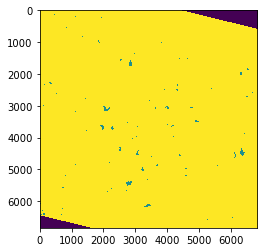

In [61]:
plt.imshow(y_arr, interpolation='none')

# Feature Importances

See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

In [62]:
rf.feature_importances_

array([0.18567521, 0.00480364, 0.00687749, 0.11415165, 0.00682245,
       0.00780446, 0.18260382, 0.00651951, 0.00679716, 0.21643983,
       0.00816578, 0.00784285, 0.09312203, 0.0142042 , 0.01384607,
       0.05146104, 0.01248067, 0.00693764, 0.03947706, 0.00777429,
       0.00619314])

In [63]:
# Guess about OSError: Too many files open (https://github.com/joblib/joblib/issues/81)
# joblib.dump(rf, out_class_dir/f'rf_{PLANET_ID}.joblib') 

# Save Data

In [64]:
chip_data = df_chip.to_dict('record')[0]
chip_data

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_29102/4294218237.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  chip_data = df_chip.to_dict('record')[0]


{'CENTERX': -95.866875,
 'CENTERY': 33.03,
 'STRATA': 3,
 'SAMPLE_ID': '3_40',
 'date': '2011-07-10',
 'LS_Validat': 1,
 'random_id': 42,
 'geometry': <shapely.geometry.polygon.Polygon at 0x1ce18afb0>}

In [65]:
df_conf.to_dict()

{'not_water': {'not_water': 58837, 'water': 0},
 'water': {'not_water': 16, 'water': 58683}}

In [66]:
fi = list(map(lambda x: f'{x:06f}', rf.feature_importances_))

In [67]:
BUCKET_NAME = 'opera-calval-dswx-jupyter'

In [68]:
class_data = {'geometry': chip_data['geometry'],
              'feature_list': 'pixels (rgb) ,mean_superpixel (rgb for 3 segs),std_superpixels for rgb image (rgb for 3 segs)',
              'feature_importances': ','.join(fi),
              'accuracy': df_conf.to_dict(),
              's3_bucket': BUCKET_NAME,
              's3_prefix': str(out_class_dir),
              's3_keys': ','.join([x.name for x in sorted(list(out_class_dir.glob('*')))]),
              'chip_id': chip_data['random_id'],
              'strata': chip_data['STRATA'],
              'planet_id': PLANET_ID
             }
class_data

{'geometry': <shapely.geometry.polygon.Polygon at 0x1ce18afb0>,
 'feature_list': 'pixels (rgb) ,mean_superpixel (rgb for 3 segs),std_superpixels for rgb image (rgb for 3 segs)',
 'feature_importances': '0.185675,0.004804,0.006877,0.114152,0.006822,0.007804,0.182604,0.006520,0.006797,0.216440,0.008166,0.007843,0.093122,0.014204,0.013846,0.051461,0.012481,0.006938,0.039477,0.007774,0.006193',
 'accuracy': {'not_water': {'not_water': 58837, 'water': 0},
  'water': {'not_water': 16, 'water': 58683}},
 's3_bucket': 'opera-calval-dswx-jupyter',
 's3_prefix': 'classification_outputs_peckel/20211003_161639_91_241d',
 's3_keys': 'chip_cropped_20211003_161639_91_241d.tif,classification_20211003_161639_91_241d.tif,classification_HAND_UPDATES_20211003_161639_91_241d.tif,metadata.geojson,occurrence_20211003_161639_91_241d.tif,superpixel_means_scale-0_20211003_161639_91_241d.tif,training_data_reprojected_20211003_161639_91_241d.tif',
 'chip_id': 42,
 'strata': 3}

In [69]:
df_out = gpd.GeoDataFrame([class_data],
                           crs=df_chip.crs)

In [70]:
df_out.to_file(out_class_dir / f'metadata.geojson', driver='GeoJSON')


# Save Running Model

Save model if does not exist

In [71]:
if not rf_path.exists():
    joblib.dump(rf, f'rf.joblib') 

    rf = None